## 10-2 エアライン乗客数の予測（LSTM）

### ライブラリーのインポート

In [1]:
import pandas as pd 
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(seed=5)

- keras.layers.LSTM
  - LSTMモデルのためのライブラリ
- sklearn.metrics
  - r2_score：決定係数を求める関数
  - mean_squared_error：平均二乗誤差を求める関数
- np.random.seed(seed=5)
  - 発生する乱数のパターンを固定する（分析処理で再現性が必要な場合に使用）

### データの読み込みと可視化

time          144
passengers    144
dtype: int64


,time,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


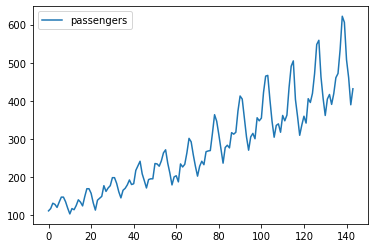

In [2]:
df = pd.read_csv('data/airline-passengers.csv')
print(df.count())
df.plot()
df.head()

### データの正規化（Mini-Max）

In [3]:
# 最小値 0、最大値 1となるように正規化する
raw_data = np.array(df['passengers'].astype('float32'))
raw_data -= np.min(np.abs(raw_data))
raw_data /= np.max(np.abs(raw_data))
# 基本統計量を確認する
pd.DataFrame(raw_data, columns=['raw_data']).describe()

,raw_data
count,144.000000
mean,0.340345
std,0.231595
min,0.000000
25%,0.146718
50%,0.311776
75%,0.495174
max,1.000000


### 訓練データの作成

In [4]:
# 訓練データのステップ数（ウィンドウサイズ）
length_of_sequence = 12
# 予測対象期間（最後の2年間）を除外したデータウィンドウ数
number_of_window = len(raw_data) - length_of_sequence - 24
# 訓練データ（data, target）の作成
x, y = [], [] 
for i in range(number_of_window):
    x.append(raw_data[i:i + length_of_sequence])
    y.append(raw_data[i + length_of_sequence])
data = np.array(x).reshape(len(x), length_of_sequence, 1)
target = np.array(y).reshape(len(y), 1)
# データの形状と要素数の確認
print(data.shape)
print(target.shape)

(108, 12, 1)
(108, 1)


- 12個の連続したデータを元に13個目のデータを予測する。
- ｘ：訓練データ（data）作成用、y：予測対象データ（target）作成用

### ハイパーパラメータの設定

In [5]:
n_hidden = 300       # 隠れ層の数
n_epochs = 100       # エポック数

### 学習モデルの構築

In [6]:
# モデル定義 
model = Sequential()
in_out_neurons = 1
model.add(
    LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons)))
model.add(Dense(in_out_neurons))
model.add(Activation('linear'))

- LSTMモデルと定義する。
  - n_hidden：隠れ層（セル）の数
  - batch_input_shape：入力データの形式（batch_size, timesteps, input_dim）

### 学習の実行

In [7]:
%%time
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(data, target, batch_size=1, epochs=n_epochs, validation_split=0.1)
predicted = model.predict(data)

Epoch 1/100
97/97 [==============================] - 4s 26ms/step - loss: 0.0115 - val_loss: 0.0268
Epoch 2/100
97/97 [==============================] - 2s 16ms/step - loss: 0.0080 - val_loss: 0.0158
Epoch 3/100
97/97 [==============================] - 2s 17ms/step - loss: 0.0075 - val_loss: 0.0148
Epoch 4/100
97/97 [==============================] - 2s 19ms/step - loss: 0.0080 - val_loss: 0.0124
Epoch 5/100
97/97 [==============================] - 1s 15ms/step - loss: 0.0043 - val_loss: 0.0112
Epoch 6/100
97/97 [==============================] - 2s 16ms/step - loss: 0.0043 - val_loss: 0.0093
Epoch 7/100
97/97 [==============================] - 2s 16ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 8/100
97/97 [==============================] - 1s 14ms/step - loss: 0.0034 - val_loss: 0.0117
Epoch 9/100
97/97 [==============================] - 2s 16ms/step - loss: 0.0043 - val_loss: 0.0124
Epoch 10/100
97/97 [==============================] - 2s 16ms/step - loss: 0.0031 - val_loss: 0.0085

- **mean_squared_error**: 平均二乗誤差

### 乗客数の予測

In [8]:
# 訓練データ区間の乗客数の予測
predicted = model.predict(data)
# 将来2年間の乗客数の予測
future_test = data[len(data)-1]    
future_result = []
for i in range(length_of_sequence * 2):
    test_data = np.reshape(future_test, (1, length_of_sequence, 1))
    batch_predict = model.predict(test_data)
    future_test = np.delete(future_test, 0)
    future_test = np.append(future_test, batch_predict)
    future_result = np.append(future_result, batch_predict)

- 学習結果を元に、1959年〜1960年を予測する処理
- future_test
  - 予測用データ（初期値はdataの最後 1958年1月〜1958年12月）
- future_result
  - 予測結果を保存するリスト

### 予測結果のプロット

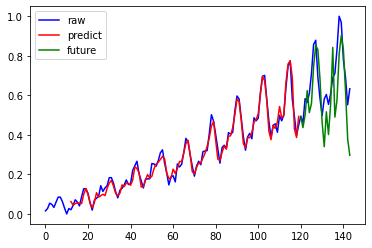

In [9]:
plt.figure()
plt.plot(range(0, len(raw_data)), raw_data, color='b', label='raw')
plt.plot(range(12,len(predicted)+12),predicted, color='r', label='predict')  
plt.plot(range(0+len(raw_data)-24, len(future_result)+len(raw_data)-24),
         future_result, color='g', label='future') 
plt.legend()
plt.show()

- fraw_data（青）
  - 元データ（1949〜1960）
- predict（赤）
  - 学習時の予測データ（1950〜1958）
- future（緑）
  - 学習後の予測データ（1959〜1960）

### 学習済みモデルの評価

In [10]:
# 決定係数と平均平方二乗誤差でモデルを評価
r2 = r2_score(target, predicted)
rmse = np.sqrt(mean_squared_error(target, predicted))
print('R2  :', r2)
print('RMSE:', rmse)

R2  : 0.9768973184747066
RMSE: 0.026502145


### 実測値と予測値の相関グラフ

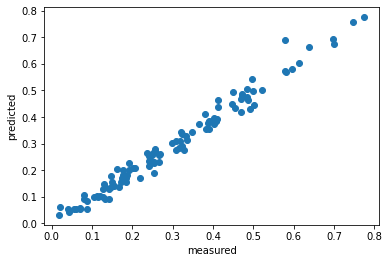

In [11]:
plt.figure()
plt.scatter(target, predicted)
plt.xlabel('measured')
plt.ylabel('predicted')
plt.show()